In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import clone, BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
from scipy import stats
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna
from optuna.samplers import TPESampler



c:\Users\Олеся\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

train_df = pd.read_csv('train_c.csv')
test_df = pd.read_csv('test_c.csv')

train_df = train_df.dropna(subset=['LoanApproved'])

X = train_df.drop(['LoanApproved', 'ID'], axis=1, errors='ignore')
y = train_df['LoanApproved']
X_test = test_df.drop('ID', axis=1)

categorical_cols = [col for col in X.columns if X[col].dtype == 'object' or col in ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel', 'BankruptcyHistory', 'PreviousLoanDefaults']]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

X[categorical_cols] = X[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)


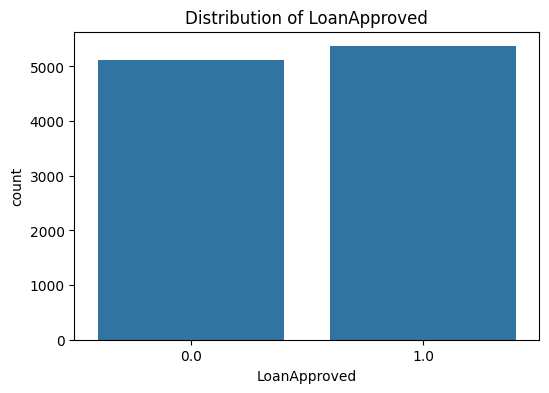

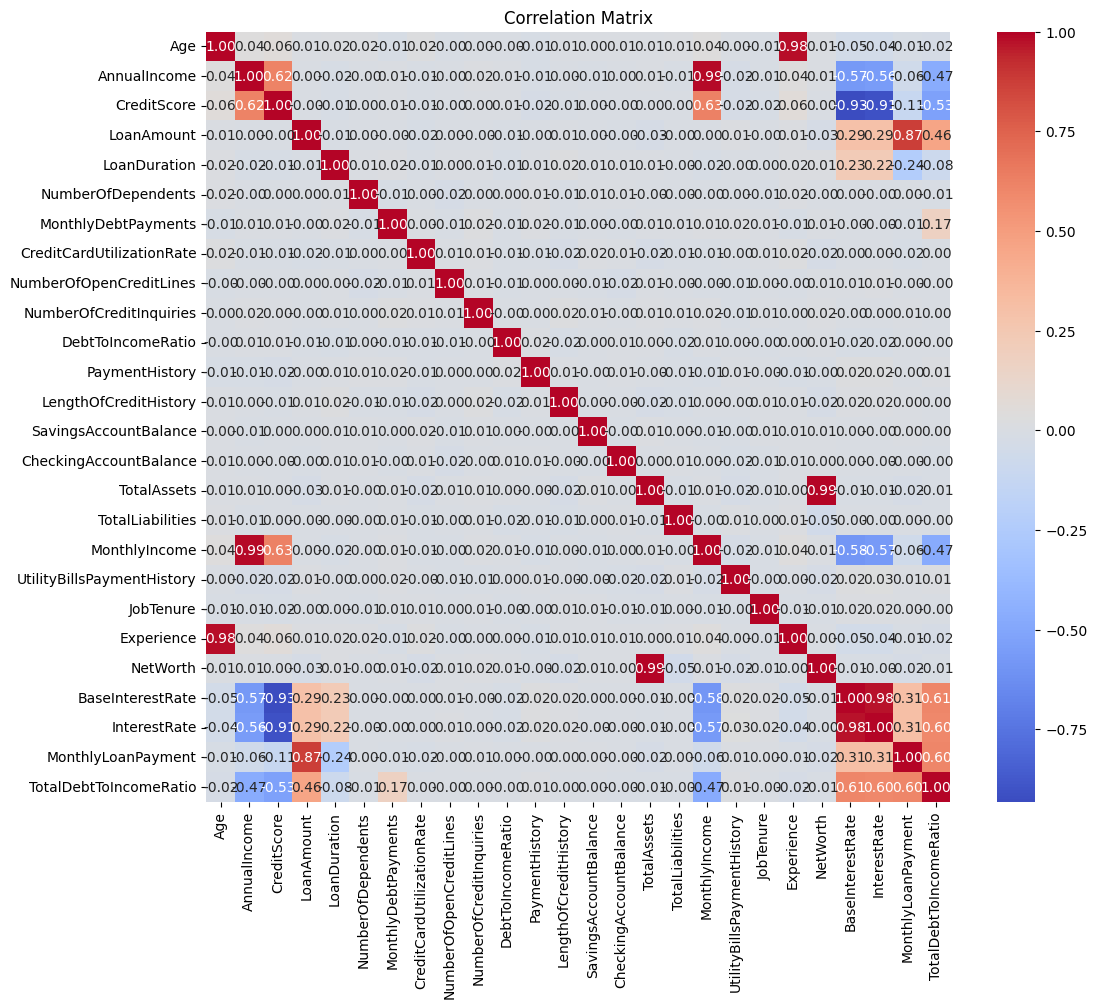

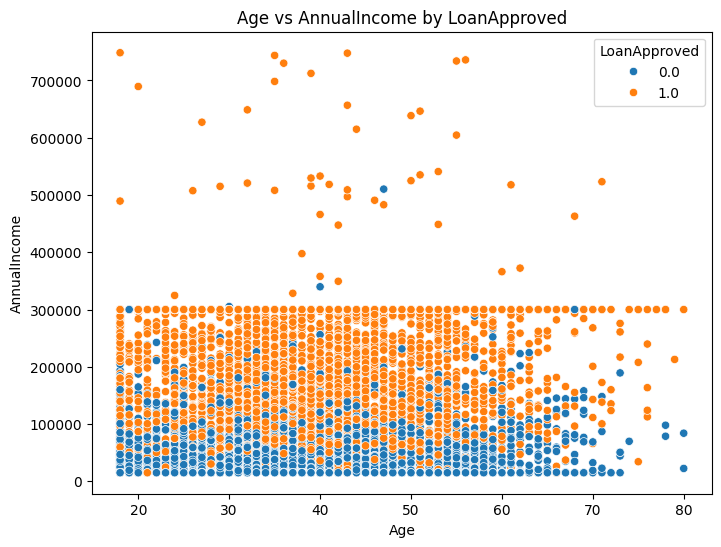

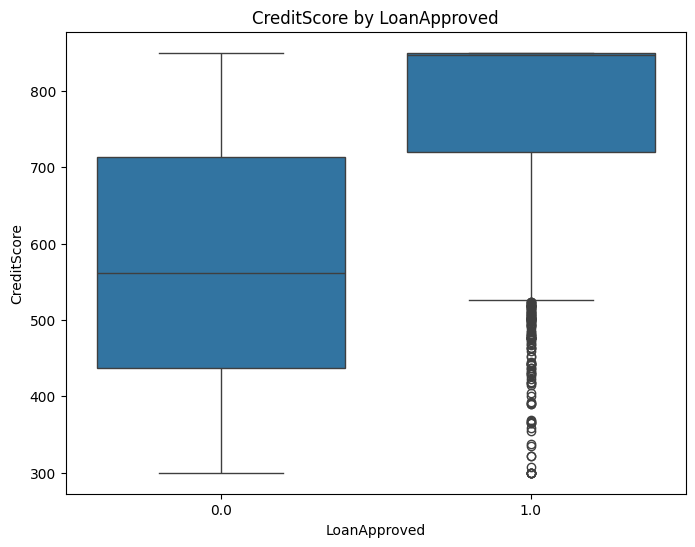

In [3]:

# Step 1: EDA (1 point)
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribution of LoanApproved')
plt.show()

num_df = X[numerical_cols].copy()
num_df = pd.concat([num_df, y], axis=1)  
corr_matrix = X[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='AnnualIncome', hue=y, data=train_df)
plt.title('Age vs AnnualIncome by LoanApproved')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=y, y='CreditScore', data=train_df)
plt.title('CreditScore by LoanApproved')
plt.show()

# Data preparation pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)
X_test_preprocessed = preprocessor.transform(X_test)

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


In [5]:

# Step 2: Implement Bagging (3 points)
class MyBaggingClassifier(BaseEstimator):
    def __init__(self, base_estimator=DecisionTreeClassifier(), n_estimators=10):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.estimators_ = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            idx = np.random.choice(X.shape[0], X.shape[0], replace=True)
            estimator = clone(self.base_estimator)
            estimator.fit(X[idx], y.iloc[idx] if isinstance(y, pd.Series) else y[idx])
            self.estimators_.append(estimator)
        return self

    def predict(self, X):
        predictions = np.array([est.predict(X) for est in self.estimators_])
        return stats.mode(predictions, axis=0)[0].flatten()

    def predict_proba(self, X):
        probas = np.array([est.predict_proba(X) for est in self.estimators_])
        return np.mean(probas, axis=0)

# Train custom bagging
my_bag = MyBaggingClassifier(n_estimators=50)
my_bag.fit(X_train, y_train)
y_pred_my_bag = my_bag.predict(X_val)
y_proba_my_bag = my_bag.predict_proba(X_val)[:, 1]

# Sklearn bagging (fixed: use estimator instead of base_estimator)
sk_bag = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
sk_bag.fit(X_train, y_train)
y_pred_sk_bag = sk_bag.predict(X_val)
y_proba_sk_bag = sk_bag.predict_proba(X_val)[:, 1]

# Compare
print(f'My Bagging ROC-AUC: {roc_auc_score(y_val, y_proba_my_bag):.4f}')
print(f'Sklearn Bagging ROC-AUC: {roc_auc_score(y_val, y_proba_sk_bag):.4f}')


My Bagging ROC-AUC: 0.9763
Sklearn Bagging ROC-AUC: 0.9775


In [6]:

# Step 3: Implement Gradient Boosting (5 points)
from sklearn.tree import DecisionTreeRegressor  # <-- важно: Regressor, а не Classifier

class MyGradientBoostingClassifier(BaseEstimator):
    def __init__(self, base_estimator=DecisionTreeRegressor(max_depth=3), n_estimators=100, learning_rate=0.1):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators_ = []
        self.initial_pred_ = None

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        p = np.clip(np.mean(y), 1e-15, 1 - 1e-15)  # защита от log(0)
        self.initial_pred_ = np.log(p / (1 - p))
        F = np.full(X.shape[0], self.initial_pred_)

        for _ in range(self.n_estimators):
            prob = self._sigmoid(F)
            residuals = y - prob
            estimator = clone(self.base_estimator)
            estimator.fit(X, residuals)  # теперь residuals — регрессионная цель
            self.estimators_.append(estimator)
            F += self.learning_rate * estimator.predict(X)
        return self

    def predict_proba(self, X):
        F = np.full(X.shape[0], self.initial_pred_)
        for est in self.estimators_:
            F += self.learning_rate * est.predict(X)
        prob = self._sigmoid(F)
        return np.column_stack([1 - prob, prob])

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)
# Train custom GB
my_gb = MyGradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
my_gb.fit(X_train, y_train)
y_pred_my_gb = my_gb.predict(X_val)
y_proba_my_gb = my_gb.predict_proba(X_val)[:, 1]

# Sklearn GB
sk_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
sk_gb.fit(X_train, y_train)
y_pred_sk_gb = sk_gb.predict(X_val)
y_proba_sk_gb = sk_gb.predict_proba(X_val)[:, 1]

# Compare
print(f'My GB ROC-AUC: {roc_auc_score(y_val, y_proba_my_gb):.4f}')
print(f'Sklearn GB ROC-AUC: {roc_auc_score(y_val, y_proba_sk_gb):.4f}')


My GB ROC-AUC: 0.9749
Sklearn GB ROC-AUC: 0.9820


In [7]:

# Step 4: Compare GB implementations (1 point)
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)
y_proba_lgb = lgb_model.predict_proba(X_val)[:, 1]
print(f'LightGBM ROC-AUC: {roc_auc_score(y_val, y_proba_lgb):.4f}')

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
print(f'XGBoost ROC-AUC: {roc_auc_score(y_val, y_proba_xgb):.4f}')

cb_model = cb.CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42, verbose=0)
cb_model.fit(X_train, y_train)
y_proba_cb = cb_model.predict_proba(X_val)[:, 1]
print(f'CatBoost ROC-AUC: {roc_auc_score(y_val, y_proba_cb):.4f}')

# Choose the best one based on the printed scores (replace if another is better)
best_model = cb_model  # Usually one of the boosted ones is best


[LightGBM] [Info] Number of positive: 4303, number of negative: 4086
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4606
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512934 -> initscore=0.051746
[LightGBM] [Info] Start training from score 0.051746
LightGBM ROC-AUC: 0.9830


c:\Users\Олеся\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


XGBoost ROC-AUC: 0.9819
CatBoost ROC-AUC: 0.9826


In [9]:

# Step 5: Optuna tuning for the best model (2 points)
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': 0
    }
    model = cb.CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, proba)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # 30-50 trials is reasonable
best_params = study.best_params
print('Best params:', best_params)

# Retrain on full data
best_model = cb.CatBoostClassifier(**best_params, verbose=0)
best_model.fit(X_preprocessed, y)


[I 2025-12-14 22:57:04,749] A new study created in memory with name: no-name-2322b656-e51d-4e8e-aa7b-c3c50fc34c8d


[I 2025-12-14 22:57:26,597] Trial 0 finished with value: 0.9815447710184552 and parameters: {'iterations': 173, 'learning_rate': 0.1926283292628157, 'depth': 10, 'l2_leaf_reg': 3.172962451282034}. Best is trial 0 with value: 0.9815447710184552.
[I 2025-12-14 22:57:34,947] Trial 1 finished with value: 0.9824037244949898 and parameters: {'iterations': 397, 'learning_rate': 0.2904625295885341, 'depth': 6, 'l2_leaf_reg': 5.2073673665422815}. Best is trial 1 with value: 0.9824037244949898.
[I 2025-12-14 22:57:41,791] Trial 2 finished with value: 0.981791095242943 and parameters: {'iterations': 323, 'learning_rate': 0.28643571703534876, 'depth': 6, 'l2_leaf_reg': 5.233894973902133}. Best is trial 1 with value: 0.9824037244949898.
[I 2025-12-14 22:57:50,260] Trial 3 finished with value: 0.9835489957970363 and parameters: {'iterations': 399, 'learning_rate': 0.09869525328606774, 'depth': 6, 'l2_leaf_reg': 1.4122795840954292}. Best is trial 3 with value: 0.9835489957970363.
[I 2025-12-14 22:58:

Best params: {'iterations': 399, 'learning_rate': 0.09869525328606774, 'depth': 6, 'l2_leaf_reg': 1.4122795840954292}


In [10]:

# Step 6: Custom metrics
def my_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def my_precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def my_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def my_f1(y_true, y_pred):
    p = my_precision(y_true, y_pred)
    r = my_recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0

y_pred_val = best_model.predict(X_val)
y_proba_val = best_model.predict_proba(X_val)[:, 1]

print(f'My Accuracy: {my_accuracy(y_val.values, y_pred_val):.4f} | sklearn: {accuracy_score(y_val, y_pred_val):.4f}')
print(f'My Precision: {my_precision(y_val.values, y_pred_val):.4f} | sklearn: {precision_score(y_val, y_pred_val):.4f}')
print(f'My Recall: {my_recall(y_val.values, y_pred_val):.4f} | sklearn: {recall_score(y_val, y_pred_val):.4f}')
print(f'My F1: {my_f1(y_val.values, y_pred_val):.4f} | sklearn: {f1_score(y_val, y_pred_val):.4f}')


My Accuracy: 0.9471 | sklearn: 0.9471
My Precision: 0.9400 | sklearn: 0.9400
My Recall: 0.9568 | sklearn: 0.9568
My F1: 0.9483 | sklearn: 0.9483


In [11]:

# Bonus metrics
def my_roc_auc(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return auc(fpr, tpr)

def my_pr_auc(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

print(f'My ROC-AUC: {my_roc_auc(y_val, y_proba_val):.4f} | sklearn: {roc_auc_score(y_val, y_proba_val):.4f}')
print(f'My PR-AUC: {my_pr_auc(y_val, y_proba_val):.4f} | sklearn (PR-AUC): {auc(*precision_recall_curve(y_val, y_proba_val)[:2][::-1]):.4f}')


My ROC-AUC: 0.9962 | sklearn: 0.9962
My PR-AUC: 0.9965 | sklearn (PR-AUC): 0.9965


In [12]:

# Final submission
test_proba = best_model.predict_proba(X_test_preprocessed)[:, 1]
test_preds = (test_proba >= 0.5).astype(int)  # or use best threshold if tuned

submission = pd.DataFrame({
    'ID': test_df['ID'],
    'LoanApproved': test_preds
})
submission.to_csv('submission.csv', index=False)
print('Submission saved! Submit to Kaggle to check ROC-AUC (>0.75 required)')

Submission saved! Submit to Kaggle to check ROC-AUC (>0.75 required)
